# Import the necessary data and modules

In [1]:
from model import model,preprocessing,data_split,highlight_entry,create_transformation,plot_dataset_splitting
from Configuration import Configuration
from gluonts.dataset import common
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt
import numpy as np
from gluonts.evaluation import make_evaluation_predictions
import gluonts
from gluonts.dataset.split import split 
config=Configuration()
df=pd.read_csv("Influenza.csv",sep=',')
display(df)

,Unnamed: 0,year,date,week,age_group,location,value
0,0,2002,2002-01-06,1,00+,LK Alb-Donau-Kreis,0.0
1,1,2002,2002-01-13,2,00+,LK Alb-Donau-Kreis,0.0
2,2,2002,2002-01-20,3,00+,LK Alb-Donau-Kreis,0.0
3,3,2002,2002-01-27,4,00+,LK Alb-Donau-Kreis,0.0
4,4,2002,2002-02-03,5,00+,LK Alb-Donau-Kreis,0.0
...,...,...,...,...,...,...,...
401104,17215,2022,2022-09-25,38,00+,StädteRegion Aachen,1.0
401105,17216,2022,2022-10-02,39,00+,StädteRegion Aachen,2.0
401106,17217,2022,2022-10-09,40,00+,StädteRegion Aachen,1.0
401107,17218,2022,2022-10-16,41,00+,StädteRegion Aachen,1.0


Problematik -> nicht alle Daten sind vorhanden -> keine gleichmäßigen Datenabstände -> gefordertes Datenformat wird nicht erfüllt
=> IN model.preprocessing():Erstelle Index mit gleichmäßigen Abständen ("W-SUN"), und füge die Daten hinzu, wenn für einen Index-Eintrag keine Daten vorhanden-> NAN

# Methodiken

## List Dataset
Umformen des Datensets in einen ListDataset()-Typ 

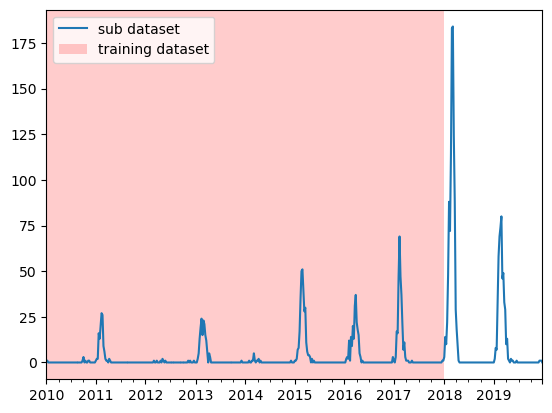

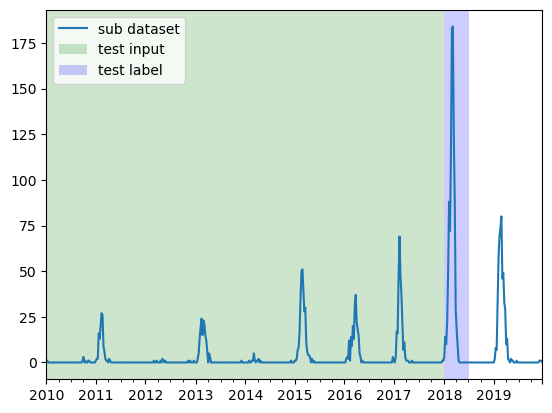

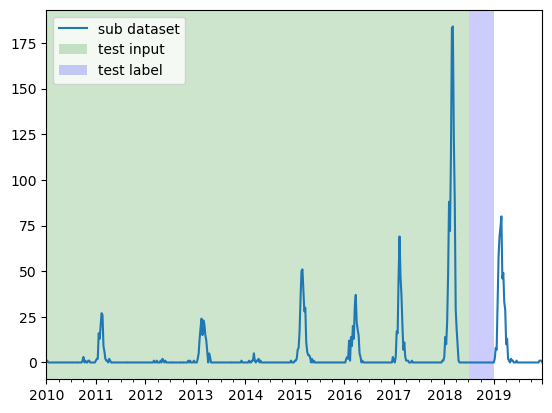

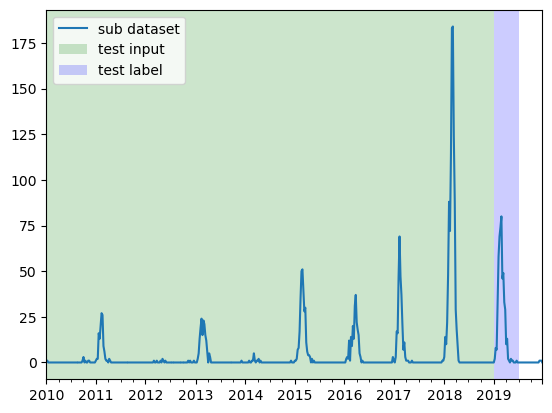

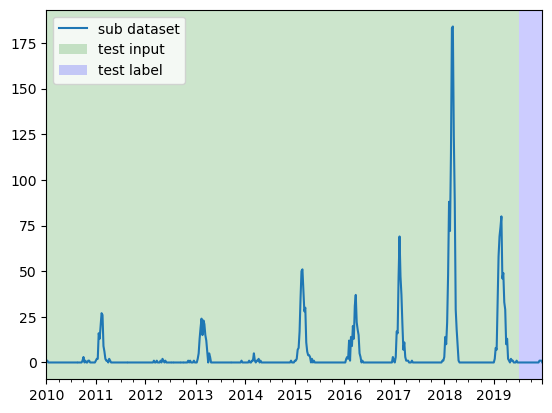

In [2]:
ld_df=preprocessing(config,df,check_count=False,output_type="LD")
training_data, test_template = split(ld_df, date=pd.Period(config.train_end_time, freq=config.freq))
test_pairs = test_template.generate_instances(prediction_length=config.prediction_length,windows=config.windows,)
plot_dataset_splitting(ld_df, training_data, test_pairs)

In [3]:
f1,t1=model(config,training_data,test_pairs)

100%|██████████| 50/50 [00:06<00:00,  7.56it/s, epoch=4/4, avg_epoch_loss=0.707]


In [4]:
print(list(f1))
#Dieser Fehler hindert uns daran die Forecasts auszugeben...

TypeError: tuple indices must be integers or slices, not str

## PandasDataset
umformen des df in ein PandasDataset resultiert allerdings in gleichem Fehler -> Wird dieser durch die Ausgabe von gluonts.dataset.split verursacht?

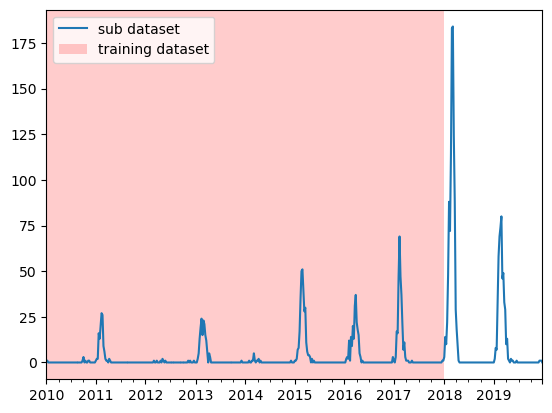

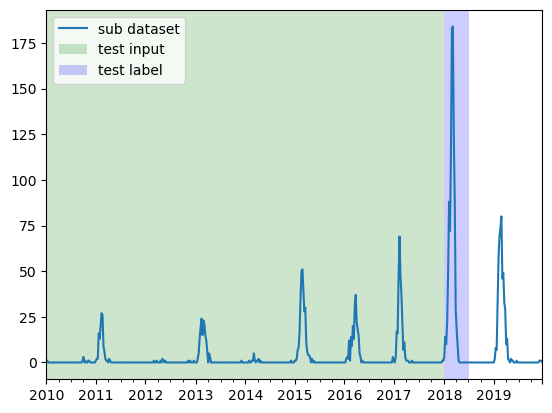

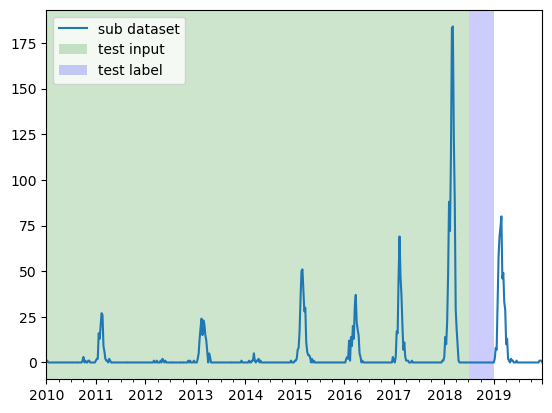

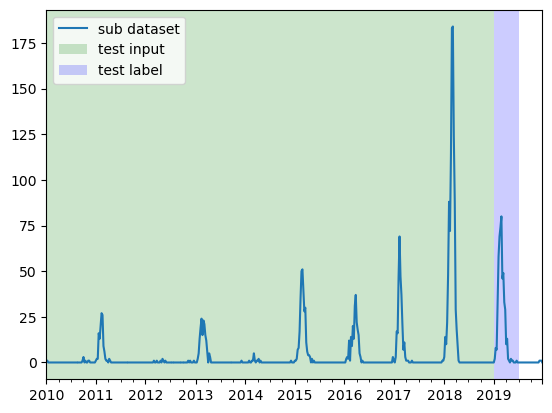

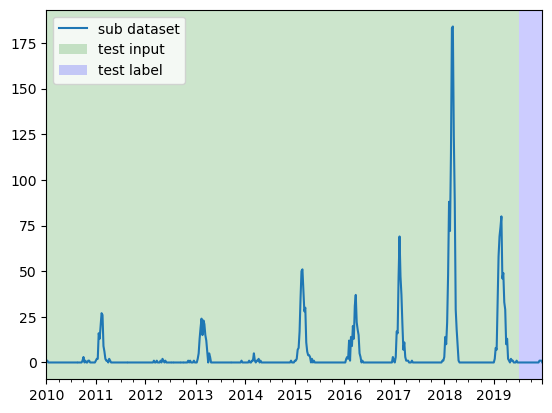

In [5]:
pd_df=preprocessing(config,df,check_count=False,output_type="PD")
training_data, test_template = split(pd_df, date=pd.Period(config.train_end_time, freq=config.freq))
test_pairs = test_template.generate_instances(prediction_length=config.prediction_length,windows=config.windows,)
plot_dataset_splitting(pd_df, training_data, test_pairs)

In [6]:
f1,t1=model(config,training_data,test_pairs)
list(f1)

100%|██████████| 50/50 [00:07<00:00,  6.81it/s, epoch=4/4, avg_epoch_loss=0.697]


TypeError: tuple indices must be integers or slices, not str

# Transformation oder eigene Implementation vorher 

In [ ]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                instance_sampler=ExpectedNumInstanceSampler(
                    num_instances=1,
                    min_future=prediction_length,
                ),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )
transformation = create_transformation(
    custom_ds_metadata["freq"],
    2 * custom_ds_metadata["prediction_length"],  # can be any appropriate value
    custom_ds_metadata["prediction_length"],
)
train_tf = transformation(iter(train_ds), is_train=True)
type(train_tf)
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]